In [1]:
import torch
import torchvision
from torchvision import transforms
from skimage import io, transform
from torch import nn

import json

import numpy as np
import pandas as pd

from training.losses import *
from training.train import *
from training.plots import *
from models.gan import *
from models.classifier import *

import matplotlib.pyplot as plt
from PIL import Image
from importlib import reload

torch.autograd.set_detect_anomaly(True)

%matplotlib inline

In [2]:
BATCH_SIZE = 128
LR = 3e-4
BETAS = 0.9, 0.999
LOGS_DIR = "./attack_gan_logdir"
DEVICE='cpu'
LAMBDA = 0.5

In [3]:
train_data = torchvision.datasets.MNIST("./../data/mnist", download=True, train=True, transform=lambda x: torch.tensor(transform.resize(np.array(x), (10, 10))).unsqueeze(0).to(dtype=torch.float32))
valid_data = torchvision.datasets.MNIST("./../data/mnist", download=True, train=False, transform=lambda x: torch.tensor(transform.resize(np.array(x), (10, 10))).unsqueeze(0).to(dtype=torch.float32))

In [4]:
base_classifier = SimpleClassifier()

base_classifier_runner = dl.SupervisedRunner(
    input_key="features", output_key="logits", target_key="targets", loss_key="loss"
)

base_classifier_runner.train(
    model=base_classifier,
    criterion= torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(base_classifier.parameters(), lr=LR, betas=BETAS),
    loaders= {
        "train": torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE, drop_last=True),
        'valid': torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, drop_last=True)
    },
    logdir="./base_classifier_logdir",
    num_epochs=3,
    valid_loader="valid",
    valid_metric="accuracy03",
    minimize_valid_metric=False,
    verbose=True,
    callbacks=[
        dl.AccuracyCallback(input_key="logits", target_key="targets", num_classes=10)
    ],
)

c:\users\seray\appdata\local\programs\python\python37\lib\site-packages\catalyst\core\runner.py:567: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  for k, v in self.batch_metrics.items()



train (1/3) accuracy: 0.884231448173523 | accuracy/std: 0.11543679123056626 | accuracy01: 0.884231448173523 | accuracy01/std: 0.11543679123056626 | accuracy03: 0.9629406929016113 | accuracy03/std: 0.06754037069869209 | accuracy05: 0.9841579794883728 | accuracy05/std: 0.04076301812779023 | loss: 0.6482267379760742 | loss/mean: 0.6482267379760742 | loss/std: 0.4372152394135142 | lr: 0.0003 | momentum: 0.9



valid (1/3) accuracy: 0.957932710647583 | accuracy/std: 0.030522644889817426 | accuracy01: 0.957932710647583 | accuracy01/std: 0.030522644889817426 | accuracy03: 0.9933894276618958 | accuracy03/std: 0.008674567084394782 | accuracy05: 0.9988982081413269 | accuracy05/std: 0.0034770481253021505 | loss: 0.2351805716753006 | loss/mean: 0.2351805716753006 | loss/std: 0.09770285679211647 | lr: 0.0003 | momentum: 0.9
* Epoch (1/3) 



train (2/3) accuracy: 0.9614049196243286 | accuracy/std: 0.019938906988731474 | accuracy01: 0.9614049196243286 | accuracy01/std: 0.019938906988731474 | accuracy03: 0.9944244027137756 | accuracy03/std: 0.006980604602343799 | accuracy05: 0.9985476732254028 | accuracy05/std: 0.003516710014875033 | loss: 0.17868296802043915 | loss/mean: 0.17868296802043915 | loss/std: 0.058125541955656175 | lr: 0.0003 | momentum: 0.9



valid (2/3) accuracy: 0.9676482081413269 | accuracy/std: 0.02526171357987263 | accuracy01: 0.9676482081413269 | accuracy01/std: 0.02526171357987263 | accuracy03: 0.9962940812110901 | accuracy03/std: 0.006467450684670552 | accuracy05: 0.9995993375778198 | accuracy05/std: 0.0017233085146153488 | loss: 0.13631899654865265 | loss/mean: 0.13631899654865265 | loss/std: 0.07301607759536155 | lr: 0.0003 | momentum: 0.9
* Epoch (2/3) 



train (3/3) accuracy: 0.9697515964508057 | accuracy/std: 0.017920160278375927 | accuracy01: 0.9697515964508057 | accuracy01/std: 0.017920160278375927 | accuracy03: 0.9960770606994629 | accuracy03/std: 0.005811909182292895 | accuracy05: 0.9990317821502686 | accuracy05/std: 0.0028621469090646585 | loss: 0.12036766856908798 | loss/mean: 0.12036766856908798 | loss/std: 0.04679955124844169 | lr: 0.0003 | momentum: 0.9



valid (3/3) accuracy: 0.9722555875778198 | accuracy/std: 0.02147488320397583 | accuracy01: 0.9722555875778198 | accuracy01/std: 0.02147488320397583 | accuracy03: 0.9984976053237915 | accuracy03/std: 0.003551279195365945 | accuracy05: 0.9996995329856873 | accuracy05/std: 0.0015024790923836488 | loss: 0.10029834508895874 | loss/mean: 0.10029834508895874 | loss/std: 0.060730404800402475 | lr: 0.0003 | momentum: 0.9
* Epoch (3/3) 
Top best models:
base_classifier_logdir\checkpoints/train.3.pth	0.9985


In [5]:
model = {"generator": Generator(), 
         "discriminator": Discriminator(), 
         'attacked_model': base_classifier.eval()}
criterion = {"generator_loss": WGANGeneratorLoss(), #GeneratorLoss(BATCH_SIZE, DEVICE), 
             "discriminator_loss": WGANDiscriminatorLoss(LAMBDA, DEVICE), #DiscriminatorLoss(BATCH_SIZE, DEVICE), 
             "attack_loss": AttackLoss(),
             "hinge_loss": HingeLoss(BATCH_SIZE, DEVICE)}
optimizer = {
    "generator_optimizer": torch.optim.Adam(model['generator'].parameters(), lr=LR, betas=BETAS),
    "discriminator_optimizer": torch.optim.Adam(model['discriminator'].parameters(), lr=LR, betas=BETAS),
}
loaders = {
    "train": torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, drop_last=True),
}

In [6]:
runner = GANRunner(BATCH_SIZE, DEVICE)

In [7]:
runner.train(
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    loaders=loaders,
    num_epochs=10,
    verbose=True,
    logdir=LOGS_DIR,
)


train (1/10) attack loss: -0.8201417326927185 | attack loss/mean: -0.8201417326927185 | attack loss/std: 0.11326456731672394 | discriminator loss: 0.1627044677734375 | discriminator loss/mean: 0.1627044677734375 | discriminator loss/std: 0.12471890430108083 | generator loss: -0.5908406376838684 | generator loss/mean: -0.5908406376838684 | generator loss/std: 0.0048453428365155685 | hinge loss: 2.6602442264556885 | hinge loss/mean: 2.6602442264556885 | hinge loss/std: 0.050686302289582694 | lr/discriminator_discriminator_optimizer: 0.0003 | lr/generator_generator_optimizer: 0.0003 | momentum/discriminator_discriminator_optimizer: 0.9 | momentum/generator_generator_optimizer: 0.9
* Epoch (1/10) 



train (2/10) attack loss: -0.9295369982719421 | attack loss/mean: -0.9295369982719421 | attack loss/std: 0.1155677359441745 | discriminator loss: 0.018984774127602577 | discriminator loss/mean: 0.018984774127602577 | discriminator loss/std: 0.015040848735300294 | generator loss: -0.6020131707191467 | generator loss/mean: -0.6020131707191467 | generator loss/std: 0.0022871530691166795 | hinge loss: 2.7800064086914062 | hinge loss/mean: 2.7800064086914062 | hinge loss/std: 0.023385983798113755 | lr/discriminator_discriminator_optimizer: 0.0003 | lr/generator_generator_optimizer: 0.0003 | momentum/discriminator_discriminator_optimizer: 0.9 | momentum/generator_generator_optimizer: 0.9
* Epoch (2/10) 



train (3/10) attack loss: -0.950262188911438 | attack loss/mean: -0.950262188911438 | attack loss/std: 0.11641701844842005 | discriminator loss: -0.0034749426413327456 | discriminator loss/mean: -0.0034749426413327456 | discriminator loss/std: 0.009445952780485762 | generator loss: -0.6087954044342041 | generator loss/mean: -0.6087954044342041 | generator loss/std: 0.0013550031934217962 | hinge loss: 2.8102519512176514 | hinge loss/mean: 2.8102519512176514 | hinge loss/std: 0.006156360874817521 | lr/discriminator_discriminator_optimizer: 0.0003 | lr/generator_generator_optimizer: 0.0003 | momentum/discriminator_discriminator_optimizer: 0.9 | momentum/generator_generator_optimizer: 0.9
* Epoch (3/10) 



train (4/10) attack loss: -0.9943538904190063 | attack loss/mean: -0.9943538904190063 | attack loss/std: 0.12117541037320277 | discriminator loss: -0.021976929157972336 | discriminator loss/mean: -0.021976929157972336 | discriminator loss/std: 0.008171182169296113 | generator loss: -0.6143203377723694 | generator loss/mean: -0.6143203377723694 | generator loss/std: 0.0015795893278871438 | hinge loss: 2.8376615047454834 | hinge loss/mean: 2.8376615047454834 | hinge loss/std: 0.009313396791474537 | lr/discriminator_discriminator_optimizer: 0.0003 | lr/generator_generator_optimizer: 0.0003 | momentum/discriminator_discriminator_optimizer: 0.9 | momentum/generator_generator_optimizer: 0.9
* Epoch (4/10) 



train (5/10) attack loss: -0.9980373978614807 | attack loss/mean: -0.9980373978614807 | attack loss/std: 0.12206835284309084 | discriminator loss: -0.03613972291350365 | discriminator loss/mean: -0.03613972291350365 | discriminator loss/std: 0.005901338951422717 | generator loss: -0.6194935441017151 | generator loss/mean: -0.6194935441017151 | generator loss/std: 0.0014292800010817178 | hinge loss: 2.851848602294922 | hinge loss/mean: 2.851848602294922 | hinge loss/std: 0.006354094198477226 | lr/discriminator_discriminator_optimizer: 0.0003 | lr/generator_generator_optimizer: 0.0003 | momentum/discriminator_discriminator_optimizer: 0.9 | momentum/generator_generator_optimizer: 0.9
* Epoch (5/10) 



train (6/10) attack loss: -1.0020482540130615 | attack loss/mean: -1.0020482540130615 | attack loss/std: 0.12265669900396094 | discriminator loss: -0.041414547711610794 | discriminator loss/mean: -0.041414547711610794 | discriminator loss/std: 0.005135689007305568 | generator loss: -0.6243388652801514 | generator loss/mean: -0.6243388652801514 | generator loss/std: 0.0012906973455176246 | hinge loss: 2.859142780303955 | hinge loss/mean: 2.859142780303955 | hinge loss/std: 0.00600947364630523 | lr/discriminator_discriminator_optimizer: 0.0003 | lr/generator_generator_optimizer: 0.0003 | momentum/discriminator_discriminator_optimizer: 0.9 | momentum/generator_generator_optimizer: 0.9
* Epoch (6/10) 



train (7/10) attack loss: -0.9998267889022827 | attack loss/mean: -0.9998267889022827 | attack loss/std: 0.12232102089457646 | discriminator loss: -0.04927128553390503 | discriminator loss/mean: -0.04927128553390503 | discriminator loss/std: 0.008300009194175876 | generator loss: -0.6293064951896667 | generator loss/mean: -0.6293064951896667 | generator loss/std: 0.001314866395239206 | hinge loss: 2.862478256225586 | hinge loss/mean: 2.862478256225586 | hinge loss/std: 0.005204806920914601 | lr/discriminator_discriminator_optimizer: 0.0003 | lr/generator_generator_optimizer: 0.0003 | momentum/discriminator_discriminator_optimizer: 0.9 | momentum/generator_generator_optimizer: 0.9
* Epoch (7/10) 



train (8/10) attack loss: -1.0027170181274414 | attack loss/mean: -1.0027170181274414 | attack loss/std: 0.12342567970505763 | discriminator loss: -0.05640452727675438 | discriminator loss/mean: -0.05640452727675438 | discriminator loss/std: 0.005625442761303584 | generator loss: -0.634095311164856 | generator loss/mean: -0.634095311164856 | generator loss/std: 0.0013091753353195608 | hinge loss: 2.8639113903045654 | hinge loss/mean: 2.8639113903045654 | hinge loss/std: 0.005726326602669584 | lr/discriminator_discriminator_optimizer: 0.0003 | lr/generator_generator_optimizer: 0.0003 | momentum/discriminator_discriminator_optimizer: 0.9 | momentum/generator_generator_optimizer: 0.9
* Epoch (8/10) 



train (9/10) attack loss: -1.0013108253479004 | attack loss/mean: -1.0013108253479004 | attack loss/std: 0.12207274428029971 | discriminator loss: -0.05834968388080597 | discriminator loss/mean: -0.05834968388080597 | discriminator loss/std: 0.008072109633784326 | generator loss: -0.6386967897415161 | generator loss/mean: -0.6386967897415161 | generator loss/std: 0.0012322442005172833 | hinge loss: 2.865696668624878 | hinge loss/mean: 2.865696668624878 | hinge loss/std: 0.006445761302798942 | lr/discriminator_discriminator_optimizer: 0.0003 | lr/generator_generator_optimizer: 0.0003 | momentum/discriminator_discriminator_optimizer: 0.9 | momentum/generator_generator_optimizer: 0.9
* Epoch (9/10) 



train (10/10) attack loss: -1.004150152206421 | attack loss/mean: -1.004150152206421 | attack loss/std: 0.12246371470810388 | discriminator loss: -0.06020016968250275 | discriminator loss/mean: -0.06020016968250275 | discriminator loss/std: 0.01119550321343003 | generator loss: -0.6430844664573669 | generator loss/mean: -0.6430844664573669 | generator loss/std: 0.0013806288134593937 | hinge loss: 2.867422342300415 | hinge loss/mean: 2.867422342300415 | hinge loss/std: 0.006119221535748031 | lr/discriminator_discriminator_optimizer: 0.0003 | lr/generator_generator_optimizer: 0.0003 | momentum/discriminator_discriminator_optimizer: 0.9 | momentum/generator_generator_optimizer: 0.9
* Epoch (10/10) 


In [8]:
attacked_model = model['attacked_model']
generator_model = model['generator']

In [9]:
val_batch = iter(torch.utils.data.DataLoader(valid_data, batch_size=BATCH_SIZE, drop_last=True)).next()

Text(0.5, 1.0, 'Fake: Prediction: 3, confidence: 0.3862351179122925')

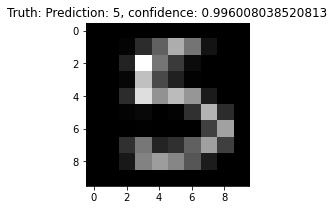

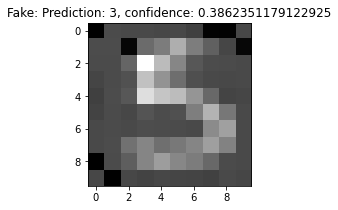

In [18]:
test_img = val_batch[0].float()[15:16]
true_confs = F.softmax(attacked_model(test_img), -1).cpu().detach().numpy()[0]
fake_confs = F.softmax(attacked_model(test_img + generator_model(test_img)), -1).cpu().detach().numpy()[0]

plt.figure(figsize=(3,3))
plt.imshow(test_img[0, 0] * 127.5 + 127.5, cmap='gray')
plt.title("Truth: Prediction: {}, confidence: {}".format(np.argmax(true_confs), true_confs.max()))

plt.figure(figsize=(3,3))
plt.imshow((test_img + generator_model(test_img).cpu().detach().numpy())[0,  0] * 127.5 + 127.5, cmap='gray')
plt.title("Fake: Prediction: {}, confidence: {}".format(np.argmax(fake_confs), fake_confs.max()))

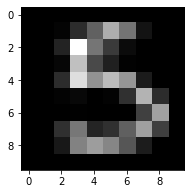

In [19]:
plt.figure(figsize=(3,3))
plt.imshow(test_img[0, 0] * 127.5 + 127.5, cmap='gray')

In [ ]:
runner.

In [25]:
results = pd.read_csv('./{}/train.csv'.format(LOGS_DIR), error_bad_lines=False, delimiter=',').loc[11:].drop(columns=['step']).astype(np.float64)
results

AttributeError: 'GANRunner' object has no attribute 'metrics'

In [20]:
results = pd.read_csv('./{}/train.csv'.format(LOGS_DIR), error_bad_lines=False, delimiter=',').loc[11:].drop(columns=['step']).astype(np.float64)
results

,attack loss,attack loss/mean,attack loss/std,discriminator loss,discriminator loss/mean,discriminator loss/std,generator loss,generator loss/mean,generator loss/std,hinge loss,hinge loss/mean,hinge loss/std,lr/discriminator_discriminator_optimizer,lr/generator_generator_optimizer,momentum/discriminator_discriminator_optimizer,momentum/generator_generator_optimizer
11,-0.820142,-0.820142,0.113265,0.162704,0.162704,0.124719,-0.590841,-0.590841,0.004845,2.660244,2.660244,0.050686,0.0003,0.0003,0.9,0.9
12,-0.929537,-0.929537,0.115568,0.018985,0.018985,0.015041,-0.602013,-0.602013,0.002287,2.780006,2.780006,0.023386,0.0003,0.0003,0.9,0.9
13,-0.950262,-0.950262,0.116417,-0.003475,-0.003475,0.009446,-0.608795,-0.608795,0.001355,2.810252,2.810252,0.006156,0.0003,0.0003,0.9,0.9
14,-0.994354,-0.994354,0.121175,-0.021977,-0.021977,0.008171,-0.614320,-0.614320,0.001580,2.837662,2.837662,0.009313,0.0003,0.0003,0.9,0.9
15,-0.998037,-0.998037,0.122068,-0.036140,-0.036140,0.005901,-0.619494,-0.619494,0.001429,2.851849,2.851849,0.006354,0.0003,0.0003,0.9,0.9
16,-1.002048,-1.002048,0.122657,-0.041415,-0.041415,0.005136,-0.624339,-0.624339,0.001291,2.859143,2.859143,0.006009,0.0003,0.0003,0.9,0.9
17,-0.999827,-0.999827,0.122321,-0.049271,-0.049271,0.008300,-0.629306,-0.629306,0.001315,2.862478,2.862478,0.005205,0.0003,0.0003,0.9,0.9
18,-1.002717,-1.002717,0.123426,-0.056405,-0.056405,0.005625,-0.634095,-0.634095,0.001309,2.863911,2.863911,0.005726,0.0003,0.0003,0.9,0.9
19,-1.001311,-1.001311,0.122073,-0.058350,-0.058350,0.008072,-0.638697,-0.638697,0.001232,2.865697,2.865697,0.006446,0.0003,0.0003,0.9,0.9
20,-1.004150,-1.004150,0.122464,-0.060200,-0.060200,0.011196,-0.643084,-0.643084,0.001381,2.867422,2.867422,0.006119,0.0003,0.0003,0.9,0.9


<AxesSubplot:>

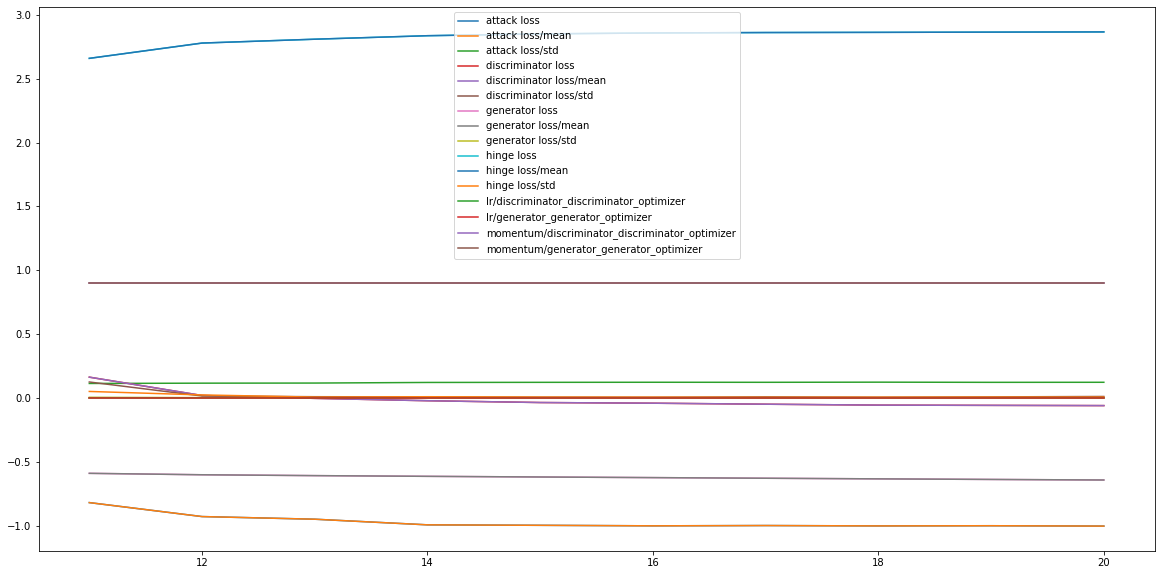

In [21]:
results.plot(figsize=(20, 10))

<AxesSubplot:>

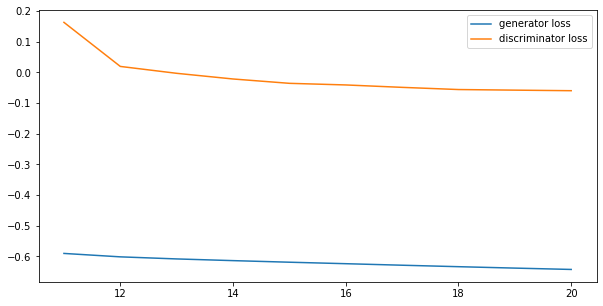

In [22]:
results[['generator loss', 'discriminator loss']].plot(figsize=(10, 5))